In [25]:
!pip install torch torchvision

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision

In [27]:
class ConvBNActivation(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, groups=1):
        # Calculate padding
        padding = (kernel_size - 1) // 2
        
        # Initialize the sequential module
        super().__init__(
            # Convolutional layer
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False),
            # Batch normalization
            nn.BatchNorm2d(out_channels),
            # ReLU6 activation
            nn.ReLU6(inplace=True)
        )

In [28]:
class InvertedResidualBlock(nn.Module):
    def __init__(self, inp, outp, stride, expand_ratio):
        super().__init__()
        # Initialize parameters
        self.stride = stride
        hidden_dim = int(inp * expand_ratio)
        self.use_shortcut = stride == 1 and inp == outp
        
        # Define layers for the block
        layers = []
        if expand_ratio != 1:
            # Add pointwise convolutional layer with expansion
            layers.append(ConvBNActivation(inp, hidden_dim, kernel_size=1))
        # Depthwise convolutional layer
        layers += [
            ConvBNActivation(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),
            # Pointwise convolutional layer
            nn.Conv2d(hidden_dim, outp, 1, 1, 0, bias=False),
            # Batch normalization
            nn.BatchNorm2d(outp),
        ]
        # Construct sequential module
        self.conv_layers = nn.Sequential(*layers)

    def forward(self, x):
        # Check if shortcut connection is needed
        if self.use_shortcut:
            return x + self.conv_layers(x)
        else:
            return self.conv_layers(x)

In [29]:
class CustomMobileNetV2(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Define the first layer
        self.first_layer = ConvBNActivation(3, 32, stride=2)
        # Define the sequence of inverted residual blocks
        self.inverted_blocks = nn.Sequential(
            InvertedResidualBlock(32, 16, 1, 1),
            InvertedResidualBlock(16, 24, 2, 6),
            InvertedResidualBlock(24, 24, 1, 6),
            InvertedResidualBlock(24, 32, 2, 6),
            InvertedResidualBlock(32, 32, 2, 6),
            InvertedResidualBlock(32, 32, 2, 6),
            InvertedResidualBlock(32, 64, 2, 6),
            InvertedResidualBlock(64, 64, 1, 6),
            InvertedResidualBlock(64, 64, 1, 6),
            InvertedResidualBlock(64, 64, 1, 6),
            InvertedResidualBlock(64, 96, 1, 6),
            InvertedResidualBlock(96, 96, 1, 6),
            InvertedResidualBlock(96, 96, 1, 6),
            InvertedResidualBlock(96, 160, 2, 6),
            InvertedResidualBlock(160, 160, 1, 6),
            InvertedResidualBlock(160, 160, 1, 6),
            InvertedResidualBlock(160, 320, 1, 6),
        )

        original_architecture = [
    # Layer 1
    {"inp": 32, "outp": 16, "stride": 1, "expand_ratio": 1},
    # Layer 2
    {"inp": 16, "outp": 24, "stride": 2, "expand_ratio": 6},
    # Layer 3
    {"inp": 24, "outp": 24, "stride": 1, "expand_ratio": 6},
    # Layer 4
    {"inp": 24, "outp": 32, "stride": 2, "expand_ratio": 6},
    # Layer 5
    {"inp": 32, "outp": 32, "stride": 1, "expand_ratio": 6},
    # Layer 6
    {"inp": 32, "outp": 32, "stride": 1, "expand_ratio": 6},
    # Layer 7
    {"inp": 32, "outp": 64, "stride": 2, "expand_ratio": 6},
    # Layer 8
    {"inp": 64, "outp": 64, "stride": 1, "expand_ratio": 6},
    # Layer 9
    {"inp": 64, "outp": 64, "stride": 1, "expand_ratio": 6},
    # Layer 10
    {"inp": 64, "outp": 64, "stride": 1, "expand_ratio": 6},
    # Layer 11
    {"inp": 64, "outp": 96, "stride": 1, "expand_ratio": 6},
    # Layer 12
    {"inp": 96, "outp": 96, "stride": 1, "expand_ratio": 6},
    # Layer 13
    {"inp": 96, "outp": 96, "stride": 1, "expand_ratio": 6},
    # Layer 14
    {"inp": 96, "outp": 160, "stride": 2, "expand_ratio": 6},
    # Layer 15
    {"inp": 160, "outp": 160, "stride": 1, "expand_ratio": 6},
    # Layer 16
    {"inp": 160, "outp": 160, "stride": 1, "expand_ratio": 6},
    # Layer 17
    {"inp": 160, "outp": 320, "stride": 1, "expand_ratio": 6},
]
        # Define the last layers
        self.last_layers = nn.Sequential(
            nn.Conv2d(320, 1280, 1),  # Adjusted input channels from 24 to 320
            nn.BatchNorm2d(1280),
            nn.ReLU6(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        # Define the output layer
        self.output_layer = nn.Linear(1280, num_classes)

    def forward(self, x):
        # Forward pass through layers
        x = self.first_layer(x)
        x = self.inverted_blocks(x)
        x = self.last_layers(x)
        x = torch.flatten(x, 1)
        x = self.output_layer(x)
        return x

In [30]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [31]:
def imshow(img):
    # Unnormalize the image
    img = img / 2 + 0.5  
    npimg = img.numpy()
    # Transpose dimensions for visualization
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [32]:
def imshow_with_labels(images, labels, predictions=None):
    # Create a grid of images
    images = torchvision.utils.make_grid(images)  
    # Unnormalize the images
    images = images / 2 + 0.5  
    np_images = images.numpy()
    # Transpose dimensions for visualization
    plt.imshow(np.transpose(np_images, (1, 2, 0)))
    title = 'True: ' + ' '.join(f'{classes[labels[j]]}' for j in range(4))
    # Add predicted labels if available
    if predictions is not None:
        title += '\nPred: ' + ' '.join(f'{classes[predictions[j]]}' for j in range(4))
    plt.title(title)
    plt.show()

In [33]:
def train_model(model, device, train_loader, optimizer, epoch, train_losses, train_accuracy):
    model.train()
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data and target to the device
        data, target = data.to(device), target.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculate the loss
        loss = nn.CrossEntropyLoss()(output, target)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()

        # Calculate training accuracy and loss
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        # Append training loss and accuracy
        train_losses.append(loss.item())
        train_accuracy.append(100. * correct / processed)
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}, Accuracy: {100. * correct / processed:.2f}%')


In [34]:
def evaluate_model(model, device, data_loader, eval_losses, eval_accuracy):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    all_predicted = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in data_loader:
            # Move images and labels to the device
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            outputs = model(images)
            # Calculate the loss
            loss = nn.CrossEntropyLoss()(outputs, labels)
            total_loss += loss.item()
            # Get the predicted labels
            _, predicted = torch.max(outputs, 1)

            # Calculate total correct predictions and total samples
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy and average loss
    accuracy = correct_predictions / total_samples
    avg_loss = total_loss / len(data_loader)

    eval_losses.append(avg_loss)
    eval_accuracy.append(accuracy * 100.0)

    print(f"Evaluation - Loss: {avg_loss:.4f}, Accuracy: {accuracy * 100:.2f}%")

    # Convert to CPU for visualization
    images = images.cpu()
    labels = labels.cpu()

    imshow_with_labels(images[:4], labels[:4], np.array(all_predicted)[:4])


In [35]:
def plot_metrics(train_losses, train_accuracy, eval_losses, eval_accuracy):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    axs[0, 0].plot(train_losses, label="Training Loss")
    axs[0, 0].set_title("Training Loss")

    axs[0, 1].plot(train_accuracy, label="Training Accuracy")
    axs[0, 1].set_title("Training Accuracy")

    axs[1, 0].plot(eval_losses, label="Evaluation Loss")
    axs[1, 0].set_title("Evaluation Loss")

    axs[1, 1].plot(eval_accuracy, label="Evaluation Accuracy")
    axs[1, 1].set_title("Evaluation Accuracy")

    plt.show()

Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.429060, Accuracy: 9.38%
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.288723, Accuracy: 12.19%
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.067304, Accuracy: 15.23%
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.040989, Accuracy: 17.43%
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.870081, Accuracy: 18.77%
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.912187, Accuracy: 20.05%
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.069053, Accuracy: 21.33%
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.798887, Accuracy: 22.27%
Evaluation - Loss: 1.7889, Accuracy: 32.38%


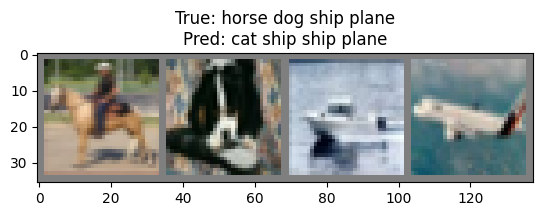

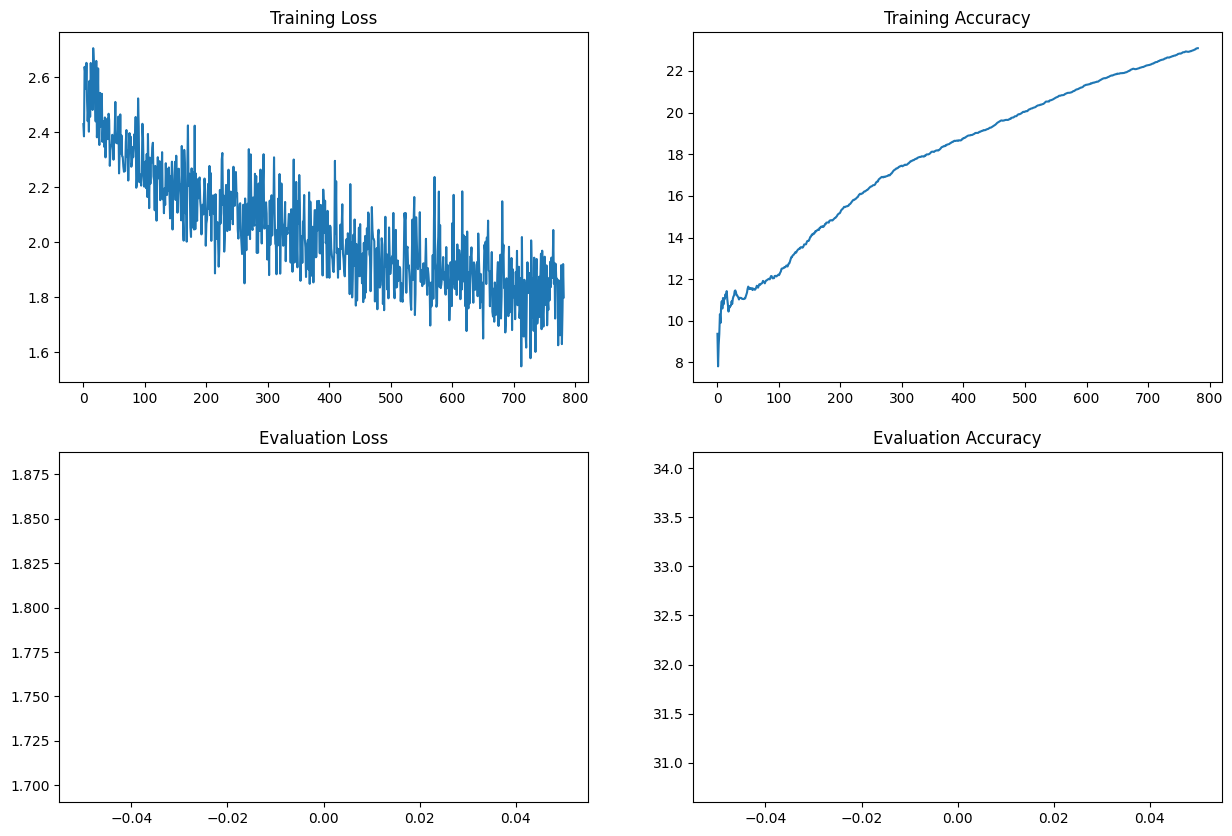

In [36]:
def main():
    # Check if MPS is available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the model, optimizer, and scheduler
    model = CustomMobileNetV2(num_classes=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    
    # Define transformations for data preprocessing
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    # Load CIFAR-10 dataset for training
    train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

    # Load CIFAR-10 dataset for testing
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
    
    train_losses, train_accuracy = [], []
    eval_losses, eval_accuracy = [], []

    # Iterate over epochs
    for epoch in range(1, 30): 
        train_model(model, device, train_loader, optimizer, epoch, train_losses, train_accuracy)

        evaluate_model(model, device, test_loader, eval_losses, eval_accuracy)
        
        # Adjust learning rate using scheduler
        scheduler.step()

    plot_metrics(train_losses, train_accuracy, eval_losses, eval_accuracy)

if __name__ == '__main__':
    main()